# Applied Data Visualization – APIs

In this lecture we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for Application Programming Interface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own GitHub client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [GitHub](https://docs.github.com/en/rest?apiVersion=2022-11-28)
 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Twitter](https://dev.twitter.com/rest/public)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
Working with an API is a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs on the web: REST (REpresentational State Transfer). REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this would be
```
https://api.twitter.com/1.1/
```

A query would look like this: 

```
https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi
```


REST APIs can return data in different forms. The most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests library](http://www.python-requests.org/en/latest/), which will handle our communication with the server.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('default')
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [2]:
import requests 
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response with the message "200". What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when an organization switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [3]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [404]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [4]:
response.content

b'{"message": "success", "iss_position": {"latitude": "-15.8201", "longitude": "-6.0119"}, "timestamp": 1699978244}'

We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [5]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [6]:
response_j = response.content.decode("utf-8")
print(response_j)

{"message": "success", "iss_position": {"latitude": "-15.8201", "longitude": "-6.0119"}, "timestamp": 1699978244}


Let's take a look at the JSON with nice formatting here:

```JSON
{
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  }, 
  "message": "success", 
  "timestamp": 1699895686
}
```

This looks a lot like a dictionary (or objects, for that matter)! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [7]:
import json
response_d = json.loads(response_j)
print(type(response_d))
print(response_d)
response_d["iss_position"]

<class 'dict'>
{'message': 'success', 'iss_position': {'latitude': '-15.8201', 'longitude': '-6.0119'}, 'timestamp': 1699978244}


{'latitude': '-15.8201', 'longitude': '-6.0119'}

Or, not surprisingly, pandas can also load a json object:

In [8]:
df = pd.read_json(response_j)
df

,message,iss_position,timestamp
latitude,success,-15.8201,2023-11-14 16:10:44
longitude,success,-6.0119,2023-11-14 16:10:44


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [9]:
def flatten(response_d):
    response_flat = {}
    response_flat["latitude"] = response_d["iss_position"]["latitude"]
    response_flat["longitude"] = response_d["iss_position"]["longitude"]
    response_flat["timestamp"] = response_d["timestamp"]
    return response_flat
flatten(response_d)

{'latitude': '-15.8201', 'longitude': '-6.0119', 'timestamp': 1699978244}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [10]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
len(iss_position)

{'latitude': '-15.8201', 'longitude': '-6.0119', 'timestamp': 1699978244}
{'latitude': '-15.6471', 'longitude': '-5.8751', 'timestamp': 1699978248}
{'latitude': '-15.4988', 'longitude': '-5.7580', 'timestamp': 1699978251}
{'latitude': '-15.3503', 'longitude': '-5.6411', 'timestamp': 1699978254}
{'latitude': '-15.2018', 'longitude': '-5.5243', 'timestamp': 1699978257}
{'latitude': '-15.0532', 'longitude': '-5.4078', 'timestamp': 1699978260}
{'latitude': '-14.9045', 'longitude': '-5.2914', 'timestamp': 1699978263}
{'latitude': '-14.7558', 'longitude': '-5.1752', 'timestamp': 1699978266}
{'latitude': '-14.6070', 'longitude': '-5.0592', 'timestamp': 1699978269}
{'latitude': '-14.4333', 'longitude': '-4.9241', 'timestamp': 1699978272}


10

Now we can convert this into a nice dataframe:

In [11]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)
iss_position_df

,latitude,longitude,timestamp
timestamp,,,
2023-11-14 16:10:44,-15.8201,-6.0119,2023-11-14 16:10:44
2023-11-14 16:10:48,-15.6471,-5.8751,2023-11-14 16:10:48
2023-11-14 16:10:51,-15.4988,-5.7580,2023-11-14 16:10:51
2023-11-14 16:10:54,-15.3503,-5.6411,2023-11-14 16:10:54
2023-11-14 16:10:57,-15.2018,-5.5243,2023-11-14 16:10:57
2023-11-14 16:11:00,-15.0532,-5.4078,2023-11-14 16:11:00
2023-11-14 16:11:03,-14.9045,-5.2914,2023-11-14 16:11:03
2023-11-14 16:11:06,-14.7558,-5.1752,2023-11-14 16:11:06
2023-11-14 16:11:09,-14.6070,-5.0592,2023-11-14 16:11:09


Let's see how the ISS moves

<Axes: xlabel='latitude', ylabel='longitude'>

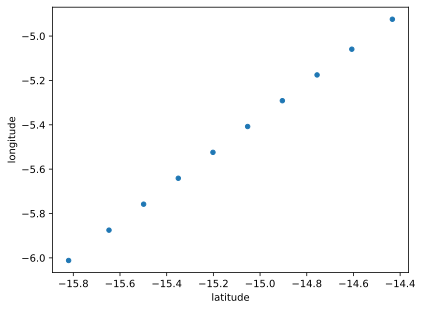

In [12]:
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### Exercise: How many Astronauts? 

Use the [Open Notify API](http://open-notify.org/Open-Notify-API/People-In-Space/) to find out how many people are in space right now.

In [13]:
# your code

## Libraries and Authentication on the Example of GitHub

While we now have the skills to directly talk to an API, it's sometimes a little tedious. Popular APIs often have existing Python libraries that wrap around them. [Here](https://github.com/realpython/list-of-python-api-wrappers) is a long list of wrappers! 

Now we'll explore the GitHub API using the [PyGithub library](https://github.com/PyGithub/PyGithub). Check out the [documentation](https://pygithub.readthedocs.io/en/stable/).

In [14]:
# run this the first time to install
#!pip install PyGitHub 


Unfortunately, most professional APIs will require you to authenticate and will limit you in what you can do – mostly they limit how much data you can retreive at a certain time. To run the following code, you'll have to put in your own credentials (sorry – I can't share mine). 

You'll need to [create a personal access token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
and save it in a file `credentials.py` in the format:
```python
key = "KEY"
```



In [15]:
from github import Github
# credentials is a local file with your own credentials. It defines a key variable with your personal access token
# you will have to load your own credentials here.
from credentials_alex import * 
g = Github(key)

Here, we have created the PyGitHub library object and authenticated against our user.

Next, we'll retrieve a bit of information about the user and print data about their followers. 

The followers come in a paginated list object, and we have to iterate over it. Behind the scenes this sends requests to the API to retrieve the information one by one. 

In [16]:
alex = g.get_user("alexsb")
print(alex)
print("----------------")
print(f"{alex.name}, {alex.bio}, {alex.company}, {alex.location}, {alex.organizations_url}")
print("----------------")
followers = alex.get_followers()
print(followers)
print("----------------")
for follower in followers[:10]:
    print(f"{follower.login}, {follower.name}, {follower.company}, {follower.location}")

NamedUser(login="alexsb")
----------------
Alexander Lex, Associate Professor of Computer Science, University of Utah, Salt Lake City, UT, USA, https://api.github.com/users/alexsb/orgs
----------------
----------------
nakao, Mitsuteru Nakao, BioRuby.org, CreativeCommons Japan, Japan
cybunk, Samuel Huron, Telecom Paris, Paris
node, Chris (Gentle) Yang, 公众号：数理话 SciBuzz, Shenzhen, China
eamonnmag, Eamonn Maguire, @protonmail , Geneva
DavidChouinard, David Chouinard, @teamcandor , San Francisco, CA
chrismattmann, Chris Mattmann, NASA, Pasadena, CA
romsson, Romain Vuillemot, LIRIS // École Centrale de Lyon, Lyon, France
williamrowell, Billy Rowell, @PacificBiosciences, Fremont, CA, US
njss, NELSON SILVA, MedUni Graz & Know-center (TU Graz), Austria
yaodong, Yaodong Zhao, None, San José, California


Obviously, we could use this information to either retreive more data about those people, or directly use it to plot / analyze the data.

# Exploring an Organization

Next, we'll explore the repositories in an organization. We'll use our lab organization as an example: https://github.com/visdesignlab/

We want to know which are the most active and popular repositories. 

First, we'll get an object that points to the organization:

In [17]:
vdl = g.get_organization("visdesignlab")
print(f"{vdl.name}, {vdl.description}, {vdl.location}, {vdl.url}")

Visualization Design Lab, Datavis Research Lab at SCI / SoC, University of Utah, Salt Lake City, UT, https://api.github.com/orgs/visdesignlab


Then we get the repositories out of it, again in a paginated list. 

In [18]:
repos = vdl.get_repos()
repos.totalCount


60

There are 60 repositories. Let's put the relevant fields in a dataframe: 

In [19]:
repos_data = []
for repo in repos:
    #print(f"{repo.name}, {repo.description}, {repo.language}, {repo.url}, {repo.created_at}, {repo.updated_at}, {repo.pushed_at}, {repo.size}, {repo.stargazers_count}, {repo.watchers_count}, {repo.forks_count}, {repo.open_issues_count}, {repo.forks}, {repo.open_issues}, {repo.watchers}, {repo.default_branch}")
    repos_data.append({
    "name": repo.name,
    "description": repo.description,
    "language": repo.language,
    "url": repo.url,
    "created_at": repo.created_at,
    "updated_at": repo.updated_at,
    "pushed_at": repo.pushed_at,
    "size": repo.size,
    "stargazers_count": repo.stargazers_count,
    "watchers_count": repo.watchers_count,
    "forks_count": repo.forks_count,
    "open_issues_count": repo.open_issues_count,
    "forks": repo.forks,
    "open_issues": repo.open_issues,
    "watchers": repo.watchers,
    "default_branch": repo.default_branch})

repos_df = pd.DataFrame(repos_data)


In [20]:
repos_df.head()

,name,description,language,url,created_at,updated_at,pushed_at,size,stargazers_count,watchers_count,forks_count,open_issues_count,forks,open_issues,watchers,default_branch
0,visdesignlab.github.io,None,HTML,https://api.github.com/repos/visdesignlab/visd...,2015-09-30 19:28:48+00:00,2023-01-31 16:39:41+00:00,2023-10-27 19:46:41+00:00,231705,5,5,19,3,19,3,5,main
1,TulipPaths,Plugins for querying paths in Tulip.,Python,https://api.github.com/repos/visdesignlab/Tuli...,2015-10-08 20:59:52+00:00,2019-02-19 04:14:22+00:00,2018-08-16 18:57:42+00:00,7403,2,2,1,0,1,0,2,master
2,graffinity_server,"Graffinity's server, includes sample Neo4j dat...",Python,https://api.github.com/repos/visdesignlab/graf...,2016-03-09 21:04:23+00:00,2020-08-26 16:37:24+00:00,2020-08-26 16:37:22+00:00,94851,4,4,2,0,2,0,4,master
3,graffinity,Graffinity: Visualizing Connectivity in Large ...,JavaScript,https://api.github.com/repos/visdesignlab/graf...,2016-04-04 19:55:24+00:00,2023-10-23 11:13:58+00:00,2022-03-01 23:39:28+00:00,15535,27,27,4,17,4,17,27,master
4,Composer,None,TypeScript,https://api.github.com/repos/visdesignlab/Comp...,2017-03-03 20:11:28+00:00,2021-08-26 14:07:52+00:00,2018-10-30 01:27:21+00:00,87088,7,7,0,0,0,0,7,master


Now let's look at a visualization of the various counts for this dataset. Check out the [paigrid dotplot](https://seaborn.pydata.org/examples/pairgrid_dotplot.html) seaborn example which this is based on. 

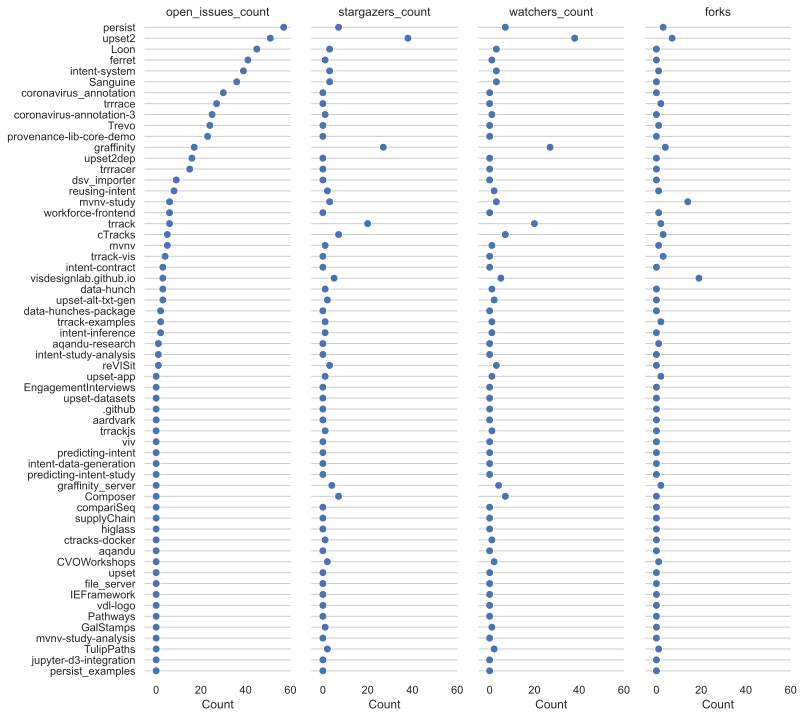

In [21]:
import seaborn as sns
sns.set_theme(style="whitegrid")

dimensions = ["open_issues_count", "stargazers_count", "watchers_count", "forks"];

# Make the PairGrid
g = sns.PairGrid(repos_df.sort_values("open_issues_count", ascending=False),
                 x_vars=repos_df[dimensions], y_vars=["name"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=8, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-5, 60), xlabel="Count", ylabel="")


for ax, title in zip(g.axes.flat, dimensions):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)